# Matter-Antimatter asymmetries at the LHC
Euan Baldwin & Luca Vicaria

### Configuration
The cell below imports all required Python modules. If you need more and add them there, make sure to execute this cell again before executing the cell requiring the new module.

In [1]:
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy.integrate import quad
from scipy.integrate import simps
from scipy.optimize import curve_fit # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
import random

### Input data
This opens input data files and assigns them to variables.

In [2]:
path = '../shared/' # set this to '' to run on the GitHub version
events_sim = uproot.open(path+'PhaseSpaceSimulation.root')
events_down = uproot.open(path+'B2HHH_MagnetDown.root')
events_up = uproot.open(path+'B2HHH_MagnetUp.root')

### Select data and calculate derived quantities
The following cell reads the input data. This is where all derived quantities (such as transverse momentum) should be calculated and where selection criteria are applied (such as the z component of the momentum being positive).

In [3]:
# Check what's in the tree. 
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print('Input data variables:')
print(events_up['DecayTree'].keys())

# These are the arrays to hold the data
pT = []
pX = []
pY = []
pZ = []
prob_pion1 = []
prob_kaon1 = []
prob_muon1 = []
prob_pion2 = []
prob_kaon2 = []
prob_muon2 = []
prob_pion3 = []
prob_kaon3 = []
prob_muon3 = []
inv_mass = []
inv_m1_m2 = []
inv_m1_m3 = []
inv_m2_m3 = []
charge1 = []
charge2 = []
charge3 = []
inv_mass_cut = []

higher_mass = []
lower_mass = []

inv_mass_resonant_cut = []
higher_mass_resonant_cut = []
lower_mass_resonant_cut = []
inv_m1_m2_resonant_cut = []
inv_m1_m3_resonant_cut = []
charge1_resonant_cut = []
charge2_resonant_cut = []
charge3_resonant_cut = []

inv_mass_resonant_cut_pos = []
inv_mass_resonant_cut_neg = []

inv_m1_m2_background = []
inv_m1_m3_background = []

inv_m1_m2_cut = []
inv_m1_m3_cut = []
inv_mass_cut_pos = []
inv_mass_cut_neg = []
charge1_cut = []
charge2_cut = []
charge3_cut = []

local_m1_m2_pos = []
local_m1_m2_neg = []
local_m1_m3_pos = []
local_m1_m3_neg = []

mass_asym_region = []
mass_asym_region_pos = []
mass_asym_region_neg = []

# A counter for bookkeeping
event_counter = 0

# If set to a value greater than 0, limits the number of events analysed
# Set to -1 to run over all events. 
# It is recommended to keep the number of events limited while developing the analysis.
MAX_EVENTS = -1

# Select which set of input data is to be analysed. Uncomment exactly one line
#trees = [events_sim['PhaseSpaceTree']]                       # Simulation
#trees = [events_down[b'DecayTree']]                          # Magnet down data
#trees = [events_up['DecayTree']]                             # Magnet up data
trees = [events_down[b'DecayTree'],events_up['DecayTree']]   # Magnet down+up data


def inv_mass_calc(H1_PX, H2_PX, H3_PX, H1_PY, H2_PY, H3_PY, H1_PZ, H2_PZ, H3_PZ):
    
        c = 1 #3*10**8 # m/s
        mass_rest_k = 493.7 # MeV/c^2
        mass_rest_pi = 139.6 # MeV/c^2
        
        PX = H1_PX + H2_PX + H3_PX
        PY = H1_PY + H2_PY + H3_PY
        PZ = H1_PZ + H2_PZ + H3_PZ
        
        P_H1 = np.sqrt(H1_PX**2 + H1_PY**2 + H1_PZ**2)
        P_H2 = np.sqrt(H2_PX**2 + H2_PY**2 + H2_PZ**2)
        P_H3 = np.sqrt(H3_PX**2 + H3_PY**2 + H3_PZ**2)

        E_H1 = np.sqrt(P_H1**2 * c**2 + mass_rest_pi**2 * c**4)
        E_H2 = np.sqrt(P_H2**2 * c**2 + mass_rest_pi**2 * c**4)
        E_H3 = np.sqrt(P_H3**2 * c**2 + mass_rest_pi**2 * c**4)
        
        mass_inv = np.sqrt((E_H1+E_H2+E_H3)**2 - (PX**2 + PY**2 + PZ**2)) 
        return mass_inv
    
    
def inv_mass_two_body(H_a_PX, H_b_PX, H_a_PY, H_b_PY, H_a_PZ, H_b_PZ):
        c = 1 #3*10**8 # m/s
        mass_rest_k = 439.7 # MeV/c^2
        mass_rest_pi = 139.6 # MeV/c^2
        
        PX = H_a_PX + H_b_PX
        PY = H_a_PY + H_b_PY
        PZ = H_a_PZ + H_b_PZ
        
        P_Ha = np.sqrt(H_a_PX**2 + H_a_PY**2 + H_a_PZ**2)
        P_Hb = np.sqrt(H_b_PX**2 + H_b_PY**2 + H_b_PZ**2)

        E_Ha = np.sqrt(P_Ha**2 * c**2 + mass_rest_pi**2 * c**4)
        E_Hb = np.sqrt(P_Hb**2 * c**2 + mass_rest_pi**2 * c**4)
        
        mass_inv = np.sqrt((E_Ha+E_Hb)**2 - (np.sqrt(PX**2 + PY**2 + PZ**2))**2) 
        return mass_inv


# This loop goes over the trees to be analysed
for tree in trees:
    # This outer loop is a technical loop of uproot over chunks of events
    for data in tree.iterate([b'H*_P[XYZ]',b'H*_Charge',b'H*_Prob*',b'H*_isMuon']):
        # As Python can handle calculations with arrays, we can calculate derived quantities here
        pT_H1 = np.sqrt(data[b'H1_PX']**2 + data[b'H1_PX']**2)
        pT_H2 = np.sqrt(data[b'H2_PX']**2 + data[b'H2_PY']**2)
        pT_H3 = np.sqrt(data[b'H3_PX']**2 + data[b'H3_PY']**2)

#       Your invariant mass calculation should go here
        mass = inv_mass_calc(data[b'H1_PX'], data[b'H2_PX'], data[b'H3_PX'], data[b'H1_PY'], data[b'H2_PY'], data[b'H3_PY'], data[b'H1_PZ'], data[b'H2_PZ'], data[b'H3_PZ'])
        
        m1_m2 = inv_mass_two_body(data[b'H1_PX'], data[b'H2_PX'], data[b'H1_PY'], data[b'H2_PY'], data[b'H1_PZ'], data[b'H2_PZ'])
        m1_m3 = inv_mass_two_body(data[b'H1_PX'], data[b'H3_PX'], data[b'H1_PY'], data[b'H3_PY'], data[b'H1_PZ'], data[b'H3_PZ'])
        m2_m3 = inv_mass_two_body(data[b'H2_PX'], data[b'H3_PX'], data[b'H2_PY'], data[b'H3_PY'], data[b'H2_PZ'], data[b'H3_PZ'])

    
        # This loop will go over individual events
        for i in range(0,len(data[b'H1_PZ'])):
            event_counter += 1
            if 0 < MAX_EVENTS and MAX_EVENTS < event_counter: break
            if 0 == (event_counter % 1000000): print('Read', event_counter, 'events')
            # Decide here which events to analyse
            if (data[b'H1_PZ'][i] < 0) or (data[b'H2_PZ'][i] < 0) or (data[b'H3_PZ'][i] < 0): continue
            
            # Fill arrays of events to be plotted and analysed further below
            # Adding values for all three hadrons to the same variable here
            pT.append(pT_H1[i])
            pT.append(pT_H2[i])
            pT.append(pT_H3[i])
            pX.append(data[b'H1_PX'][i])
            pX.append(data[b'H2_PX'][i])
            pX.append(data[b'H3_PX'][i])
            pY.append(data[b'H1_PY'][i])
            pY.append(data[b'H2_PY'][i])
            pY.append(data[b'H3_PY'][i])
            pZ.append(data[b'H1_PZ'][i])
            pZ.append(data[b'H2_PZ'][i])
            pZ.append(data[b'H3_PZ'][i])
            
            prob_pion1.append(data[b'H1_ProbPi'][i])
            prob_pion2.append(data[b'H2_ProbPi'][i])
            prob_pion3.append(data[b'H3_ProbPi'][i])
            
            prob_kaon1.append(data[b'H1_ProbK'][i])
            prob_kaon2.append(data[b'H2_ProbK'][i])
            prob_kaon3.append(data[b'H3_ProbK'][i])
            
            prob_muon1.append(data[b'H1_isMuon'][i])
            prob_muon2.append(data[b'H2_isMuon'][i])
            prob_muon3.append(data[b'H3_isMuon'][i])
            
            charge1.append(data[b'H1_Charge'][i])  # Append the charge of H1
            charge2.append(data[b'H2_Charge'][i])  # Append the charge of H2
            charge3.append(data[b'H3_Charge'][i])  # Append the charge of H3
            
            inv_mass.append(mass[i])
    
            # Cut out particles that are likely to be kaons, aren't likely to be pions and aren't muons
            if (data[b'H1_isMuon'][i] == 1) or (data[b'H2_isMuon'][i] == 1) or (data[b'H3_isMuon'][i] == 1): continue
            if ((data[b'H1_ProbK'][i] > 0.9) or (data[b'H2_ProbK'][i] > 0.9) or (data[b'H3_ProbK'][i] > 0.9)): continue
            if ((data[b'H1_ProbPi'][i] < 0.1) or (data[b'H2_ProbPi'][i] < 0.1) or (data[b'H3_ProbPi'][i] < 0.1)): continue
            if ((data[b'H1_ProbK'][i]) * (data[b'H2_ProbK'][i]) * (data[b'H3_ProbK'][i])) > 0.2: continue
            if ((data[b'H1_ProbPi'][i]) * (data[b'H2_ProbPi'][i]) * (data[b'H3_ProbPi'][i])) < 0.7: continue

            inv_mass_cut.append(mass[i])

#             # The two body masses should be neutral
#             if (charge1[i] + charge2[i]) == 0:
#                 inv_m1_m2.append(m1_m2[i])

#             if (charge1[i] + charge3[i]) == 0:
#                 inv_m1_m3.append(m1_m3[i])

#             if (charge2[i] + charge3[i]) == 0:
#                 inv_m2_m3.append(m2_m3[i])

            # This showed us that m2_m3 should not be used as the charges never add to 0, 
            # whereas the other combinations always add to zero 

            # Create arrays for the higher and lower of the two body masses                
            higher_mass.append(max(m1_m2[i], m1_m3[i]))
            lower_mass.append(min(m1_m2[i], m1_m3[i]))
            
            D_0_meson_mass = 1864
            high_cut = 1864 + 30
            low_cut = 1864 - 30
                
            # Cut out the resonance
            if (1834 < m1_m2[i] < 1894) or (1834 < m1_m3[i] < 1894): continue

            inv_mass_resonant_cut.append(mass[i])
            higher_mass_resonant_cut.append(max(m1_m2[i], m1_m3[i]))
            lower_mass_resonant_cut.append(min(m1_m2[i], m1_m3[i]))
            inv_m1_m2_resonant_cut.append(m1_m2[i])
            inv_m1_m3_resonant_cut.append(m1_m3[i])
            
            # Split out the region where we think there is significant asymmetry
            if (0 < m1_m2[i]) and (m1_m2[i] < 2740):
                if (3870 < m1_m3[i]) and (m1_m3[i] < 4470):
                    mass_asym_region.append(mass[i])
                    if (charge1[i] + charge2[i] + charge3[i]) == 1:
                        mass_asym_region_pos.append(mass[i])
                    if (charge1[i] + charge2[i] + charge3[i]) == -1:
                        mass_asym_region_neg.append(mass[i])
                    
            # Split the data by positive and negative charge
            if (charge1[i] + charge2[i] + charge3[i]) == 1:
                inv_mass_resonant_cut_pos.append(mass[i])
            if (charge1[i] + charge2[i] + charge3[i]) == -1:
                inv_mass_resonant_cut_neg.append(mass[i])
                
            # Create a sample of the background data
            if (5400 < mass[i]) and (mass[i] < 5500):
                inv_m1_m2_background.append(m1_m2[i])
                inv_m1_m3_background.append(m1_m3[i])
    
            # Cut data not around the event peak
            if (5225 < mass[i]) or (mass[i] > 5340): continue

            inv_m1_m2_cut.append(m1_m2[i])
            inv_m1_m3_cut.append(m1_m3[i])
            charge1_cut.append(charge1[i])
            charge2_cut.append(charge2[i])
            charge3_cut.append(charge3[i])
            
            if (charge1[i] + charge2[i] + charge3[i]) == 1:
                local_m1_m2_pos.append(m1_m2[i])
                local_m1_m3_pos.append(m1_m3[i])
                
            if (charge1[i] + charge2[i] + charge3[i]) == -1:
                local_m1_m2_neg.append(m1_m2[i])
                local_m1_m3_neg.append(m1_m3[i])

            

print(f'Read {event_counter:d} events')
print(f'{len(inv_mass_cut)/len(inv_mass):%}')

print(f'Total events after cutting: {len(inv_mass_resonant_cut_pos) + len(inv_mass_resonant_cut_neg)}')

Input data variables:
[b'B_FlightDistance', b'B_VertexChi2', b'H1_PX', b'H1_PY', b'H1_PZ', b'H1_ProbK', b'H1_ProbPi', b'H1_Charge', b'H1_IPChi2', b'H1_isMuon', b'H2_PX', b'H2_PY', b'H2_PZ', b'H2_ProbK', b'H2_ProbPi', b'H2_Charge', b'H2_IPChi2', b'H2_isMuon', b'H3_PX', b'H3_PY', b'H3_PZ', b'H3_ProbK', b'H3_ProbPi', b'H3_Charge', b'H3_IPChi2', b'H3_isMuon']
Read 1000000 events
Read 2000000 events
Read 3000000 events
Read 4000000 events
Read 5000000 events
Read 6000000 events
Read 7000000 events
Read 8000000 events
Read 8556118 events
1.259520%
Total events after cutting: 103019


### Histogram of Classification Probabilities

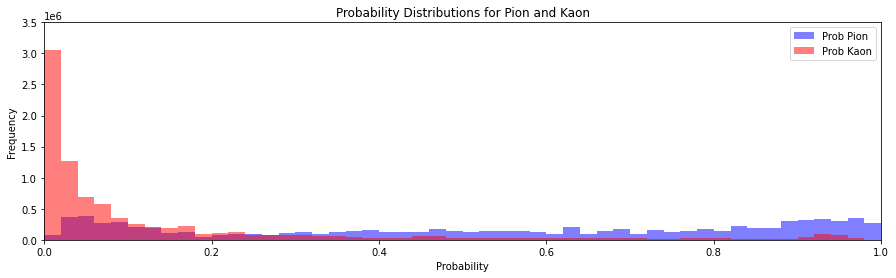

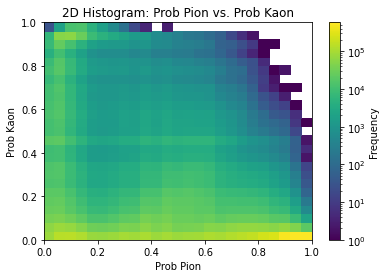

<Figure size 432x288 with 0 Axes>

In [4]:
# Create 1D histogram
plt.figure(figsize=(15,4))
plt.hist(prob_pion1, bins=50, range=(0,1), alpha=0.5, label='Prob Pion', color='blue')
plt.hist(prob_kaon1, bins=50, range=(0,1), alpha=0.5, label='Prob Kaon', color='red')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Probability Distributions for Pion and Kaon')
plt.xlim(0, 1)
plt.ylim(0, 3.5e6)
plt.legend()
plt.show()

# Create a 2D histogram
plt.hist2d(prob_pion1, prob_kaon1, bins=(25, 25), range=((0, 1), (0, 1)),norm=colors.LogNorm())
plt.xlabel('Prob Pion')
plt.ylabel('Prob Kaon')
plt.title('2D Histogram: Prob Pion vs. Prob Kaon')
plt.colorbar(label='Frequency')
plt.show()


### Invariant Mass Plot

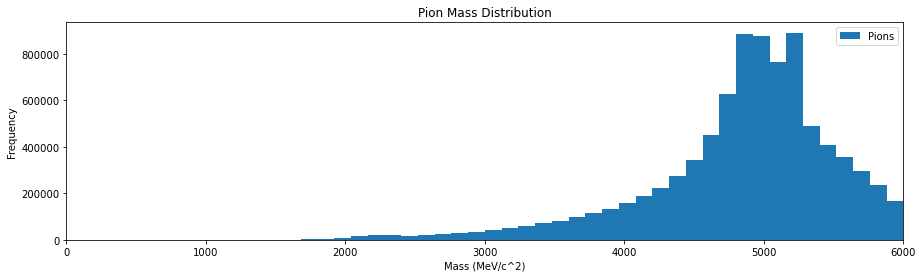

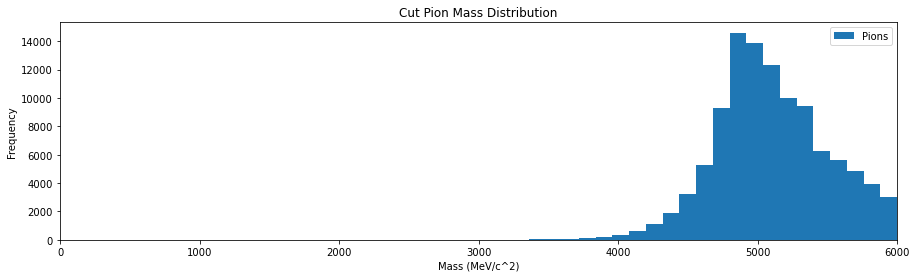

In [5]:
def inv_mass_plot(inv_mass, title):    
    # Create 1D histogram
    plt.figure(figsize=(15,4))
    plt.xlim(0, 6000)
    plt.hist(inv_mass, range=(0,6000), bins=50, label='Pions')
    plt.xlabel('Mass (MeV/c^2)')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()  # Show the saved figure

    
inv_mass_plot(inv_mass, 'Pion Mass Distribution')
inv_mass_plot(inv_mass_cut, 'Cut Pion Mass Distribution')

## Two-body Resonances

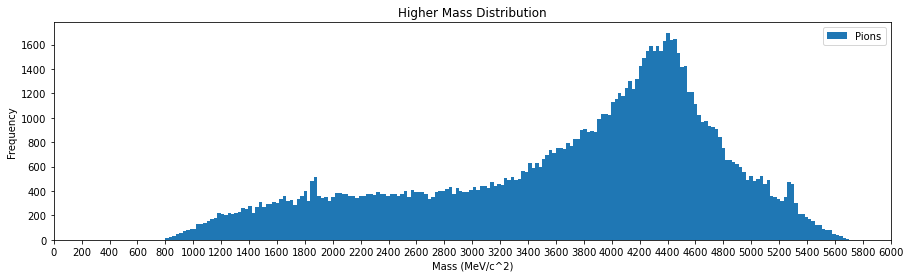

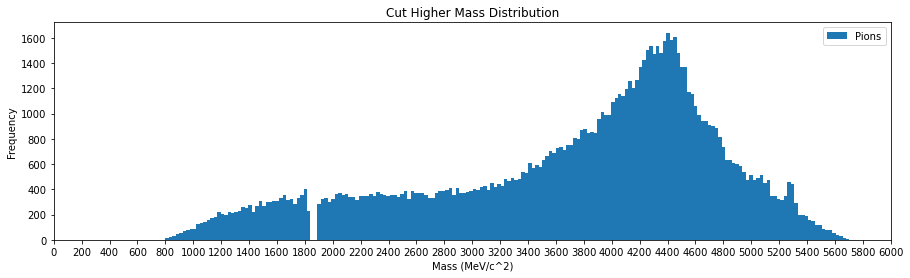

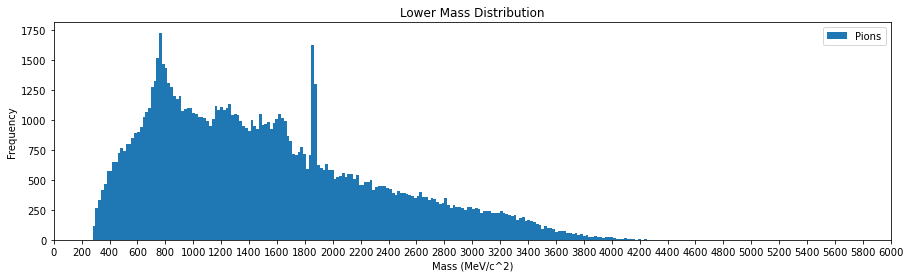

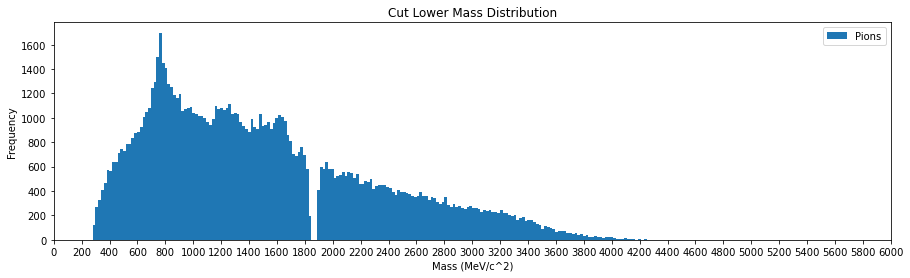

In [6]:
def inv_mass_plot_two(inv_mass, title):    
    # Create 1D histogram
    plt.figure(figsize=(15,4))
    plt.hist(inv_mass, bins=200, label='Pions')
    x_ticks = [i for i in range(0, 6001, 200)]
    plt.xticks(x_ticks)
    plt.xlabel('Mass (MeV/c^2)')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()  # Show the saved figure

N_BIN = 25
    
inv_mass_plot_two(higher_mass, 'Higher Mass Distribution')
inv_mass_plot_two(higher_mass_resonant_cut, 'Cut Higher Mass Distribution')
inv_mass_plot_two(lower_mass, 'Lower Mass Distribution')
inv_mass_plot_two(lower_mass_resonant_cut, 'Cut Lower Mass Distribution')

In [7]:
N_BIN = 25
            
def plot_resonant_cut(inv_mass, title):
    # Create a histogram using np.histogram
    counts, bin_edges = np.histogram(inv_mass, range=(5050, 5500), bins=N_BIN)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, counts
"""
    plt.figure(figsize=(10, 5))
    
    # Create a scatter plot of peak values against bin centers
    plt.scatter(bin_centers, counts, marker='x', color='k', label='Peak Values', s=60, linewidths=2)

    plt.xlabel('Mass (MeV/c^2)')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()  # Show the saved figure
"""
    
            
x, y = plot_resonant_cut(inv_mass_resonant_cut, 'Resonant Cut Pion Mass Distributions')

## Fitting

Chi-squared: 40.499
Degrees of freedom: 17
Reduced Chi-squared: 2.382


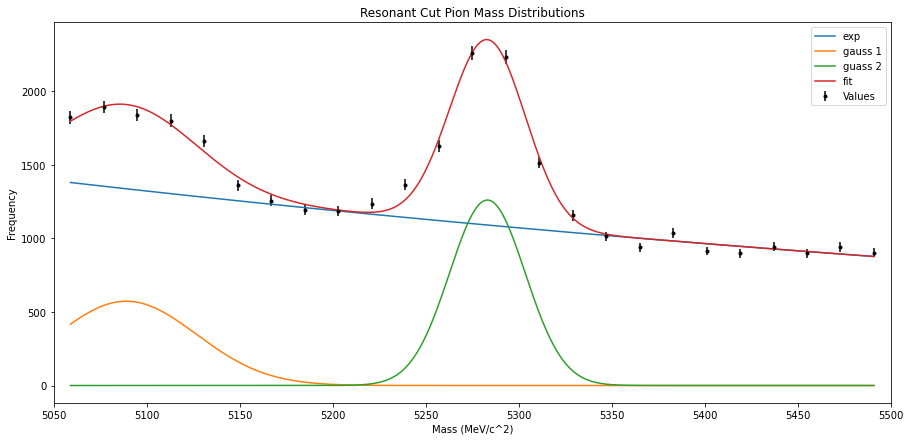

[ 2.78348063e+05  1.04909727e-03  5.72749909e+02  5.08906602e+03
 -3.77146472e+01  1.25990401e+03  5.28316452e+03  2.03534761e+01]


In [8]:
def gauss(x, A, x0, sigma): 
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss2(x, A2, x02, sigma2): 
    return A2 * np.exp(-(x - x02) ** 2 / (2 * sigma2 ** 2))

def exp(x, a, b):
    return a * np.exp(- b * x)

def fitting_func(x, a, b, A, x0, sigma, A2, x02, sigma2):
    return np.array( gauss(x, A, x0, sigma) + exp(x, a, b) + gauss2(x, A2, x02, sigma2))


def fit(f, x, y, guess):
    popt, pcov = curve_fit(f, x, y, p0=guess, maxfev = 500000)
    yfit = f(x, *popt)
    return yfit, popt


yfit, popt = fit(fitting_func, x, y, [4.58061153e+04, 1.06520033e-03, 9.27486437e+01, 5.08564026e+03,
 4.32309356e+01, 2.31380945e+02, 5.28254844e+03, 1.92424648e+01])


def calculate_chi_squared(observed, expected):
    residuals = observed - expected
    chi_squared = np.sum(residuals**2 / expected)
    return chi_squared


chi_squared = calculate_chi_squared(y, yfit)
dof = len(y) - len(popt)
reduced_chi_squared = chi_squared/dof

print(f"Chi-squared: {chi_squared:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"Reduced Chi-squared: {reduced_chi_squared:.3f}")


def plot_resonant_cut_fit(inv_mass, yfit, title, popt):
    # Create a histogram using np.histogram
    counts, bin_edges = np.histogram(inv_mass, range=(5050, 5500), bins=N_BIN)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]

    plt.figure(figsize=(15, 7))
    
    # Create a scatter plot of peak values against bin centers
#    plt.scatter(bin_centers, counts, marker='x', color='k', label='Peak Values', s=60, linewidths=2)
    plt.errorbar(bin_centers, counts, np.sqrt(counts), marker='.', color='k', label='Values', linestyle='')
#    plt.plot(bin_centers, yfit)
    
    y_exp = exp(bin_centers, popt[0], popt[1])
    y_gauss = gauss(bin_centers, popt[2], popt[3], popt[4])
    y_gauss2 = gauss(bin_centers, popt[5], popt[6], popt[7])
    
    x_vals_for_plot = np.linspace(min(bin_centers), max(bin_centers), 1000)
    y_exp_for_plot = exp(x_vals_for_plot, popt[0], popt[1])
    y_gauss_for_plot = gauss(x_vals_for_plot, popt[2], popt[3], popt[4])
    y_gauss2_for_plot = gauss(x_vals_for_plot, popt[5], popt[6], popt[7])
    y_fitting_func_for_plot = fitting_func(x_vals_for_plot, *popt)

    plt.plot(x_vals_for_plot, y_exp_for_plot, label='exp')
    plt.plot(x_vals_for_plot, y_gauss_for_plot, label='gauss 1')
    plt.plot(x_vals_for_plot, y_gauss2_for_plot, label='guass 2')
    plt.plot(x_vals_for_plot, y_fitting_func_for_plot, label='fit')
    
    plt.xlim(5050, 5500)
    plt.xlabel('Mass (MeV/c^2)')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()  # Show the saved figure
    return bin_centers, y_gauss, y_exp, bin_width, popt


def calculate_area(func, start, end, popt):
    area, _ = quad(func, start, end, args=(popt))
    return area


xval, _, y_exp, bin_w_all, popt_all = plot_resonant_cut_fit(inv_mass_resonant_cut, yfit, 'Resonant Cut Pion Mass Distributions', popt)

N_background_under_signal = calculate_area(exp, 5225, 5340, (popt_all[0], popt_all[1]))
#N_background_under_signal = calculate_area(exp, 5150, 5300, (popt_all[0], popt_all[1])) / bin_w_all

print(popt_all)

## Global CP Asymmetry

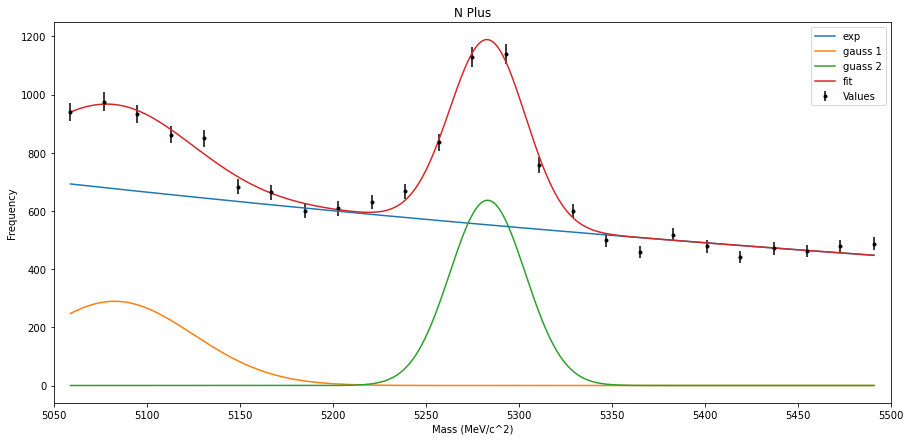

In [9]:
x_pos, y_pos = plot_resonant_cut(inv_mass_resonant_cut_pos, 'N Plus')
yfit_pos, popt_pos = fit(fitting_func, x_pos, y_pos, [4.58061153e+04, 1.06520033e-03, 9.27486437e+01, 5.08564026e+03,
 4.32309356e+01, 2.31380945e+02, 5.28254844e+03, 1.92424648e+01])
x_values_pos, y_gauss_pos, y_exp_pos, bin_w_pos, popt_pos = plot_resonant_cut_fit(inv_mass_resonant_cut_pos, yfit_pos, 'N Plus', popt_pos)


N_pos = calculate_area(gauss, 5100, 5400, (popt_pos[5], popt_pos[6], popt_pos[7]))
#N_pos = calculate_area(gauss, 5100, 5400, (popt_pos[2], popt_pos[3], popt_pos[4])) / bin_w_pos
#N_pos_2 = simps(y_gauss_pos, x_values_pos) / bin_w_pos

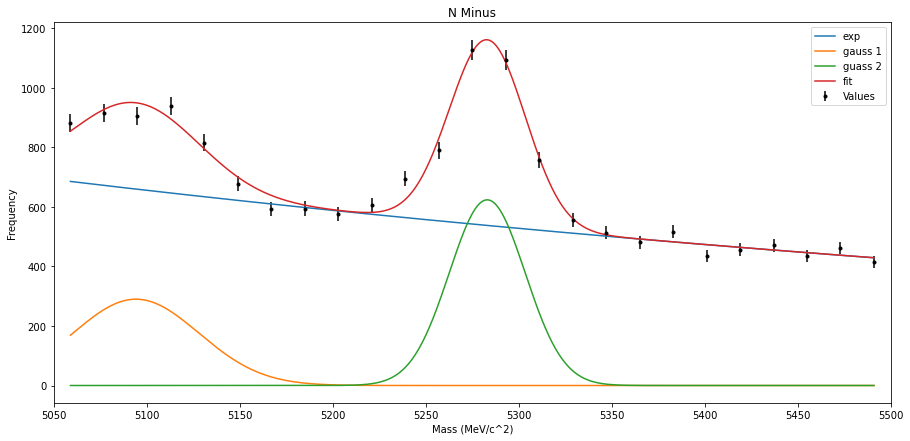

[1.65004893e+05 1.08399958e-03 2.89855717e+02 5.09420729e+03
 3.38674105e+01 6.23474763e+02 5.28307071e+03 2.04191063e+01]


In [10]:
x_neg, y_neg = plot_resonant_cut(inv_mass_resonant_cut_neg, 'N Minus')
yfit_neg, popt_neg = fit(fitting_func, x_neg, y_neg, [4.58061153e+04, 1.06520033e-03, 9.27486437e+01, 5.08564026e+03,
 4.32309356e+01, 2.31380945e+02, 5.28254844e+03, 1.92424648e+01])
x_values_neg, y_gauss_neg, y_exp_neg, bin_w_neg, popt_neg = plot_resonant_cut_fit(inv_mass_resonant_cut_neg, yfit_neg, 'N Minus', popt_neg)

print(popt_neg)

#N_neg2 = simps(y_gauss_neg, x_values_neg) / bin_w_neg
N_neg = calculate_area(gauss, 5100, 5400, (popt_neg[5], popt_neg[6], popt_neg[7]))

In [11]:
global_asymmetry = (N_neg - N_pos)/(N_neg + N_pos)
global_asymmetry_unc = np.sqrt((1-global_asymmetry**2)/(N_neg + N_pos))


print(f"Percent asymmetry: ({global_asymmetry*100:.3} ± {global_asymmetry_unc*100:.2})%")

Percent asymmetry: (-0.793 ± 0.39)%


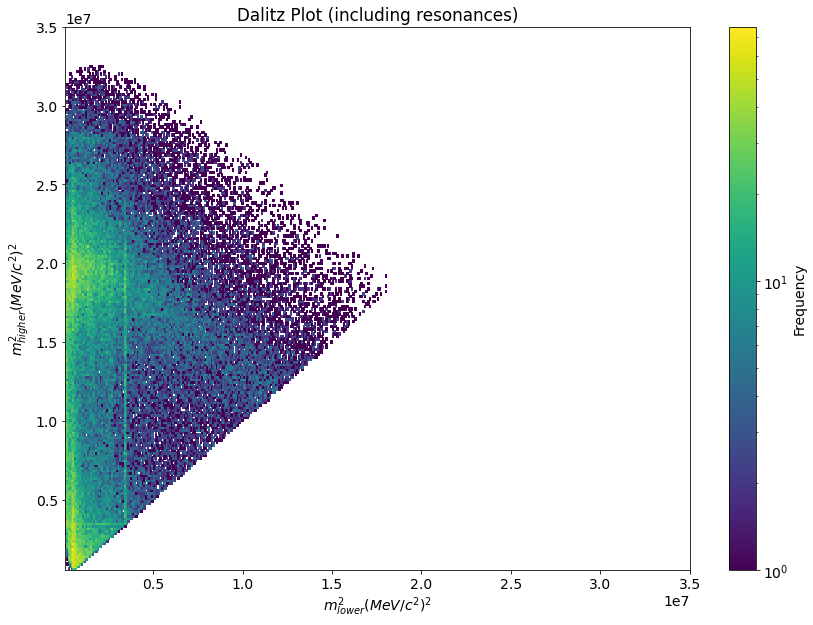

<Figure size 432x288 with 0 Axes>

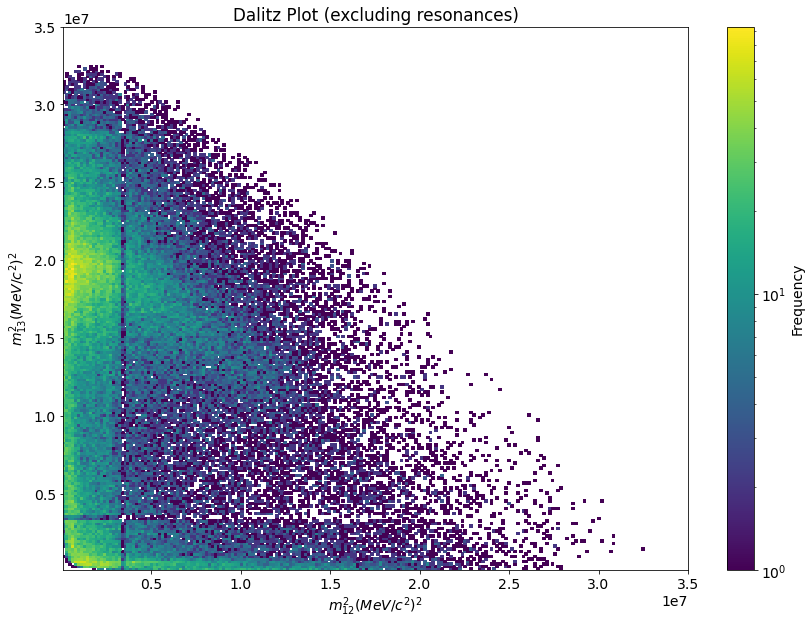

<Figure size 432x288 with 0 Axes>

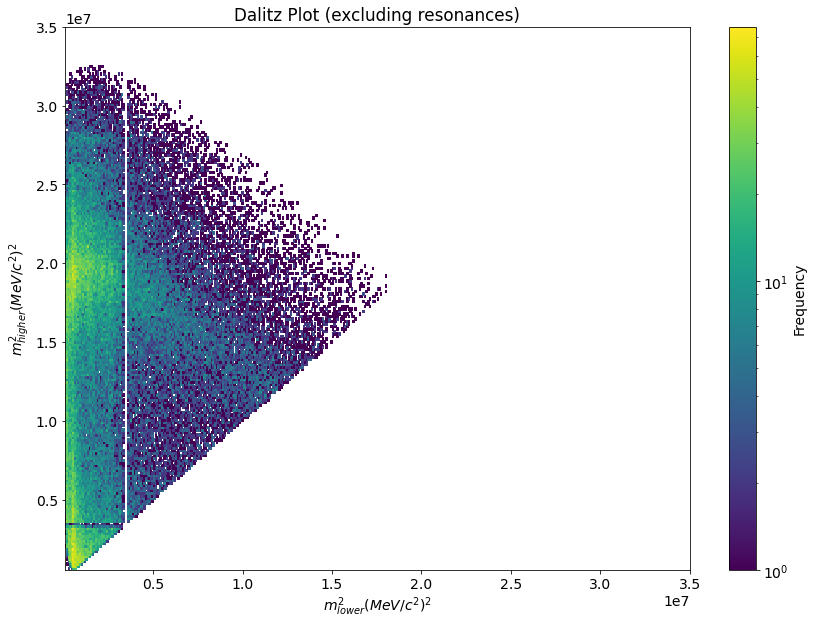

<Figure size 432x288 with 0 Axes>

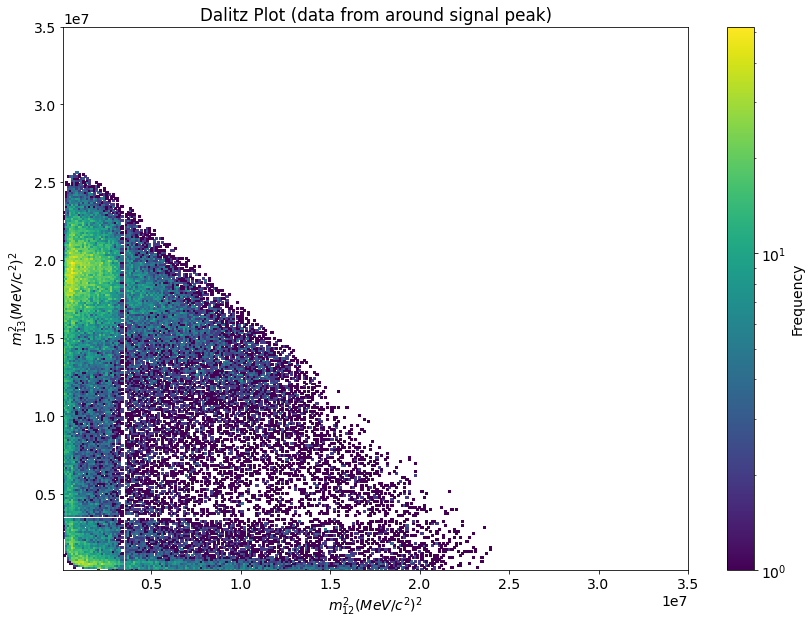

<Figure size 432x288 with 0 Axes>

In [12]:
N_BINS = 200

def dalitz_plot(mass_a, mass_b, title, x_label, y_label):
    plt.figure(figsize=(14, 10))
    plt.rcParams.update({'font.size': 14})
#    plt.hist2d(np.array(mass_a)**2/10e6, np.array(mass_b)**2/10e6, bins=(N_BINS, N_BINS), norm=colors.LogNorm())
#    plt.hist2d(np.array(mass_a), np.array(mass_b), bins=(N_BINS, N_BINS), norm=colors.LogNorm())
    plt.hist2d(np.array(mass_a)**2, np.array(mass_b)**2, bins=(N_BINS, N_BINS), norm=colors.LogNorm())
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
#    plt.xlim(left=-0.1)
#    plt.ylim(bottom=-0.1)
    
    plt.xlim(right=3.5e7)
    plt.ylim(top=3.5e7)
#    plt.axhline(0, c='k', ls='--', lw=1)
#    plt.axvline(0, c='k', ls='--', lw=1)
    
#    plt.axhline(.34e7, c='k', ls='--', lw=1)
#    plt.axvline(.34e7, c='k', ls='--', lw=1)
    
#    interval = 0.1
#    x_ticks = [i * interval for i in range(0, int(3.4/interval)+1)]
#    plt.xticks(x_ticks)
#    plt.yticks(x_ticks)
    plt.colorbar(label='Frequency')
    plt.show()


x_label = f'$m_{{12}}^2 (MeV/c^2)^2$'
y_label = f'$m_{{13}}^2 (MeV/c^2)^2$'
    
dalitz_plot(lower_mass, higher_mass, 'Dalitz Plot (including resonances)', f'$m_{{lower}}^2 (MeV/c^2)^2$', f'$m_{{higher}}^2 (MeV/c^2)^2$')
dalitz_plot(inv_m1_m2_resonant_cut, inv_m1_m3_resonant_cut, 'Dalitz Plot (excluding resonances)', x_label, y_label)
dalitz_plot(lower_mass_resonant_cut, higher_mass_resonant_cut, 'Dalitz Plot (excluding resonances)', f'$m_{{lower}}^2 (MeV/c^2)^2$', f'$m_{{higher}}^2 (MeV/c^2)^2$')
dalitz_plot(inv_m1_m2_cut, inv_m1_m3_cut, 'Dalitz Plot (data from around signal peak)', x_label, y_label)


## Subtracting Background Events

In [13]:
SCALE_FACTOR = N_background_under_signal / len(inv_m1_m2_background)

print(SCALE_FACTOR)

24.647796681320916


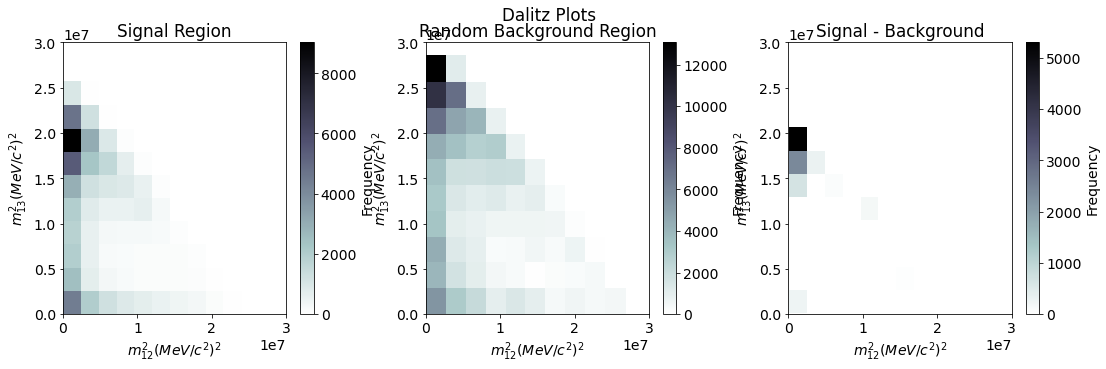

In [14]:
CMAP_BINS = 10

import matplotlib.colors as mcolors

cmap = 'bone_r'

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

h2d1 = ax[0].hist2d(np.array(inv_m1_m2_cut)**2, np.array(inv_m1_m3_cut)**2, bins=[CMAP_BINS,CMAP_BINS], cmap='bone_r')

weights = np.full_like(inv_m1_m2_background, SCALE_FACTOR)
h2d2 = ax[1].hist2d(np.array(inv_m1_m2_background)**2, np.array(inv_m1_m3_background)**2, bins=[CMAP_BINS,CMAP_BINS], cmap=cmap, weights=weights)

x_edges = h2d1[1]
y_edges = h2d1[2]

# Compute the weighted histogram for invariant_m1_m2_cut data
weights_cut = np.ones_like(inv_m1_m2_cut)
h2d1_weighted, _, _ = np.histogram2d(np.array(inv_m1_m2_cut)**2, 
                                     np.array(inv_m1_m3_cut)**2, 
                                     bins=[x_edges, y_edges], 
                                     weights=weights_cut)

# Compute the weighted histogram for invariant_m1_m2_background data
h2d2_weighted, _, _ = np.histogram2d(np.array(inv_m1_m2_background)**2, 
                                     np.array(inv_m1_m3_background)**2, 
                                     bins=[x_edges, y_edges], 
                                     weights=weights)


# Subtract the weighted histograms
h2d3_data = h2d1_weighted - h2d2_weighted

# Clip negative values to 0
h2d3_data = np.clip(h2d3_data, a_min=0, a_max=None)


min_val, max_val = np.min(h2d3_data), np.max(h2d3_data)

if abs(min_val) > abs(max_val):
    greatest_mag_val = min_val
else:
    greatest_mag_val = max_val

# Define a custom colormap that is white at zero and adjusts for the data range
norm = mcolors.TwoSlopeNorm(vmin=-greatest_mag_val, vcenter=0, vmax=greatest_mag_val)

# Plot the third histogram using imshow for better control over the appearance
h2d3 = ax[2].imshow(h2d3_data.T, interpolation='nearest', origin='lower',
                    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                    cmap=cmap, aspect='auto')

ax[0].set_title('Signal Region')
ax[1].set_title('Random Background Region')
ax[2].set_title('Signal - Background')

# Add colorbars for the histograms
fig.colorbar(h2d1[3], ax=ax[0], label='Frequency')  # Colorbar for h2d1
fig.colorbar(h2d2[3], ax=ax[1], label='Frequency')  # Colorbar for h2d2
fig.colorbar(h2d3, ax=ax[2], label='Frequency')  # Colorbar for h2d3

for axis in ax:
    axis.set_xlabel(f'$m_{{12}}^2 (MeV/c^2)^2$')
    axis.set_ylabel(f'$m_{{13}}^2 (MeV/c^2)^2$')
    axis.set_xlim(0, 3e7)
    axis.set_ylim(0, 3e7)
    

fig.suptitle('Dalitz Plots')

plt.show()

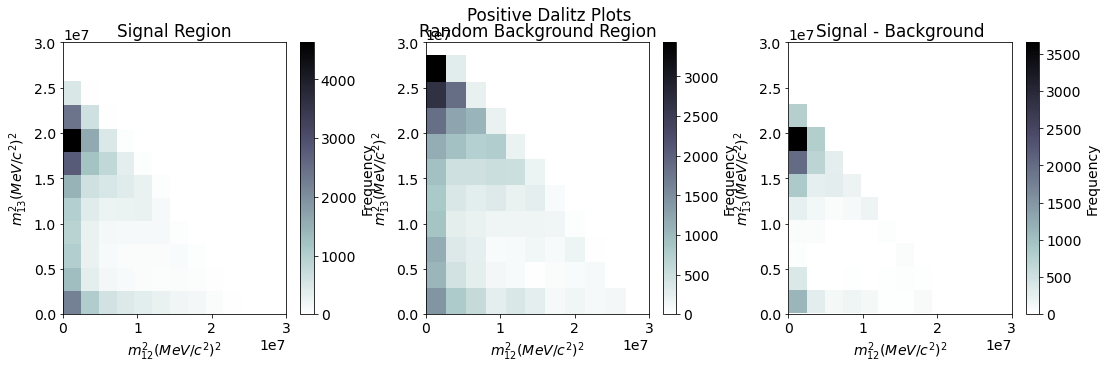

In [15]:
SCALE_FACTOR_pos = len(local_m1_m2_pos) / len(inv_m1_m2_background)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

h2d1 = ax[0].hist2d(np.array(local_m1_m2_pos)**2, np.array(local_m1_m3_pos)**2, bins=[CMAP_BINS,CMAP_BINS], cmap=cmap)

weights = np.full_like(inv_m1_m2_background, SCALE_FACTOR_pos)
h2d2 = ax[1].hist2d(np.array(inv_m1_m2_background)**2, np.array(inv_m1_m3_background)**2, bins=[CMAP_BINS,CMAP_BINS], cmap=cmap, weights=weights)

x_edges = h2d1[1]
y_edges = h2d1[2]

# Compute the weighted histogram for invariant_m1_m2_cut data
weights_cut = np.ones_like(local_m1_m2_pos)
h2d1_weighted, _, _ = np.histogram2d(np.array(local_m1_m2_pos)**2, 
                                     np.array(local_m1_m3_pos)**2, 
                                     bins=[x_edges, y_edges], 
                                     weights=weights_cut)

# Compute the weighted histogram for invariant_m1_m2_background data
h2d2_weighted, _, _ = np.histogram2d(np.array(inv_m1_m2_background)**2, 
                                     np.array(inv_m1_m3_background)**2, 
                                     bins=[x_edges, y_edges], 
                                     weights=weights)


# Subtract the weighted histograms
h2d3_data_pos = h2d1_weighted - h2d2_weighted

# Clip negative values to 0
h2d3_data_pos = np.clip(h2d3_data_pos, a_min=0, a_max=None)

# Plot the third histogram using imshow for better control over the appearance
h2d3_pos = ax[2].imshow(h2d3_data_pos.T, interpolation='nearest', origin='lower',
                    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                    cmap=cmap, aspect='auto')

ax[0].set_title('Signal Region')
ax[1].set_title('Random Background Region')
ax[2].set_title('Signal - Background')

# Add colorbars for the histograms
fig.colorbar(h2d1[3], ax=ax[0], label='Frequency')  # Colorbar for h2d1
fig.colorbar(h2d2[3], ax=ax[1], label='Frequency')  # Colorbar for h2d2
fig.colorbar(h2d3_pos, ax=ax[2], label='Frequency')  # Colorbar for h2d3

for axis in ax:
    axis.set_xlabel(f'$m_{{12}}^2 (MeV/c^2)^2$')
    axis.set_ylabel(f'$m_{{13}}^2 (MeV/c^2)^2$')
    axis.set_xlim(0, 3e7)
    axis.set_ylim(0, 3e7)
    
fig.suptitle('Positive Dalitz Plots')

plt.show()

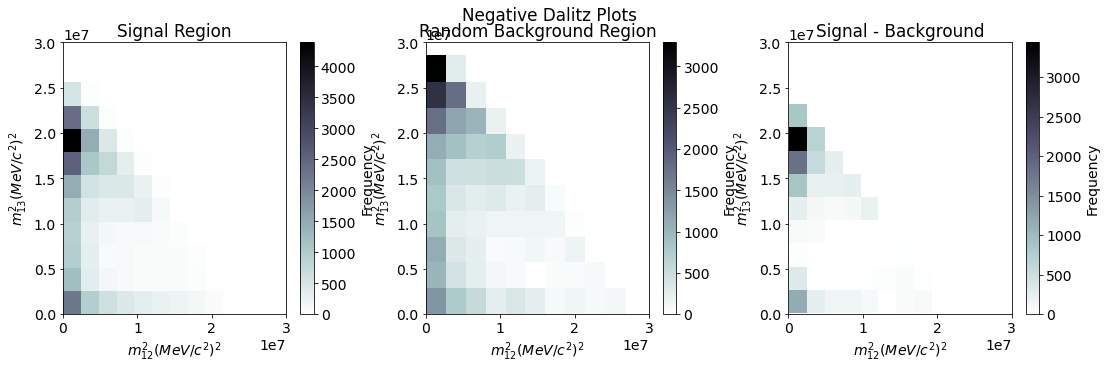

In [16]:
SCALE_FACTOR_neg = len(local_m1_m2_neg) / len(inv_m1_m2_background)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

h2d1 = ax[0].hist2d(np.array(local_m1_m2_neg)**2, np.array(local_m1_m3_neg)**2, bins=[CMAP_BINS,CMAP_BINS], cmap=cmap)

weights = np.full_like(inv_m1_m2_background, SCALE_FACTOR_neg)
h2d2 = ax[1].hist2d(np.array(inv_m1_m2_background)**2, np.array(inv_m1_m3_background)**2, bins=[CMAP_BINS,CMAP_BINS], cmap=cmap, weights=weights)

x_edges = h2d1[1]
y_edges = h2d1[2]

# Compute the weighted histogram for invariant_m1_m2_cut data
weights_cut = np.ones_like(local_m1_m2_neg)
h2d1_weighted, _, _ = np.histogram2d(np.array(local_m1_m2_neg)**2, 
                                     np.array(local_m1_m3_neg)**2, 
                                     bins=[x_edges, y_edges], 
                                     weights=weights_cut)

# Compute the weighted histogram for invariant_m1_m2_background data
h2d2_weighted, _, _ = np.histogram2d(np.array(inv_m1_m2_background)**2, 
                                     np.array(inv_m1_m3_background)**2, 
                                     bins=[x_edges, y_edges], 
                                     weights=weights)


# Subtract the weighted histograms
h2d3_data_neg = h2d1_weighted - h2d2_weighted

# Clip negative values to 0
h2d3_data_neg = np.clip(h2d3_data_neg, a_min=0, a_max=None)

# Plot the third histogram using imshow for better control over the appearance
h2d3_neg = ax[2].imshow(h2d3_data_neg.T, interpolation='nearest', origin='lower',
                    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                    cmap=cmap, aspect='auto')

ax[0].set_title('Signal Region')
ax[1].set_title('Random Background Region')
ax[2].set_title('Signal - Background')

# Add colorbars for the histograms
fig.colorbar(h2d1[3], ax=ax[0], label='Frequency')  # Colorbar for h2d1
fig.colorbar(h2d2[3], ax=ax[1], label='Frequency')  # Colorbar for h2d2
fig.colorbar(h2d3_neg, ax=ax[2], label='Frequency')  # Colorbar for h2d3

for axis in ax:
    axis.set_xlabel(f'$m_{{12}}^2 (MeV/c^2)^2$')
    axis.set_ylabel(f'$m_{{13}}^2 (MeV/c^2)^2$')
    axis.set_xlim(0, 3e7)
    axis.set_ylim(0, 3e7)
    
fig.suptitle('Negative Dalitz Plots')
plt.show()

In [17]:
h2d3_data_asymmetry = (h2d3_data_neg - h2d3_data_pos) / (h2d3_data_neg + h2d3_data_pos)
h2d3_data_asymmetry = np.where(h2d3_data_asymmetry < -0.99, 0, h2d3_data_asymmetry)
h2d3_data_asymmetry = np.where(h2d3_data_asymmetry > 0.85, 0, h2d3_data_asymmetry)

norm_asymmetry = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

asymmetry_unc = np.sqrt((1-h2d3_data_asymmetry**2)/(h2d3_data_pos + h2d3_data_neg))
asymmetry_unc = np.where(asymmetry_unc > .5, 0, asymmetry_unc)


h2d3_data_asymmetry_sig = h2d3_data_asymmetry / (asymmetry_unc) 
h2d3_data_asymmetry_sig = np.where(h2d3_data_asymmetry_sig < -1000, 0, h2d3_data_asymmetry_sig)

min_val, max_val = np.nanmin(h2d3_data_asymmetry_sig), np.nanmax(h2d3_data_asymmetry_sig)
if abs(min_val) > abs(max_val):
    greatest_magnitude_val = abs(min_val)
else:
    greatest_magnitude_val = abs(max_val)

norm_sig = mcolors.TwoSlopeNorm(vmin=-greatest_magnitude_val, vcenter=0, vmax=greatest_magnitude_val)

<ipython-input-17-a87f62402516>:1: RuntimeWarning: invalid value encountered in true_divide
  h2d3_data_asymmetry = (h2d3_data_neg - h2d3_data_pos) / (h2d3_data_neg + h2d3_data_pos)
<ipython-input-17-a87f62402516>:11: RuntimeWarning: invalid value encountered in true_divide
  h2d3_data_asymmetry_sig = h2d3_data_asymmetry / (asymmetry_unc)


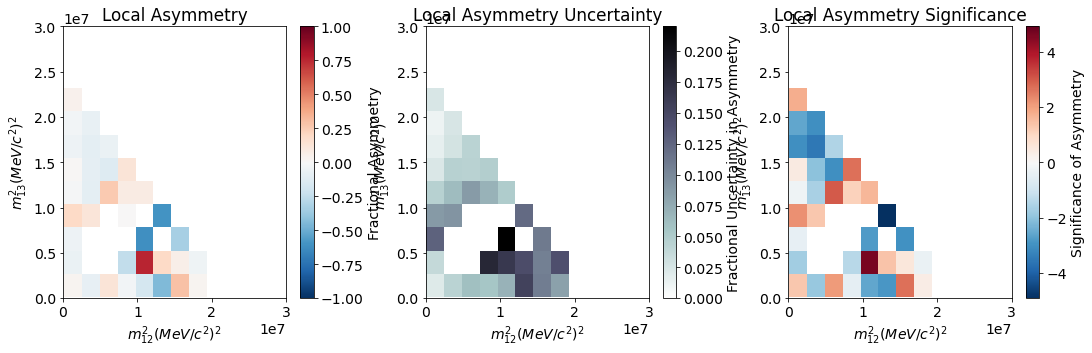

In [18]:
# Creating a combined plot with three subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3)  # increase horizontal space between plots

# Asymmetry Plot
im1 = ax[0].imshow(h2d3_data_asymmetry.T, interpolation='nearest', origin='lower',
                    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                    cmap='RdBu_r', norm=norm_asymmetry, aspect='auto')
plt.colorbar(im1, ax=ax[0], label='Fractional Asymmetry')
ax[0].set_xlabel(f'$m_{{12}}^2 (MeV/c^2)^2$')
ax[0].set_ylabel(f'$m_{{13}}^2 (MeV/c^2)^2$')
ax[0].set_title('Local Asymmetry')

# Uncertainty Plot
im2 = ax[1].imshow(asymmetry_unc.T, interpolation='nearest', origin='lower',
                    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                    cmap=cmap, aspect='auto')
plt.colorbar(im2, ax=ax[1], label='Fractional Uncertainty in Asymmetry')
ax[1].set_xlabel(f'$m_{{12}}^2 (MeV/c^2)^2$')
ax[1].set_ylabel(f'$m_{{13}}^2 (MeV/c^2)^2$')
ax[1].set_title('Local Asymmetry Uncertainty')

# Significance Plot
im3 = ax[2].imshow(h2d3_data_asymmetry_sig.T, interpolation='nearest', origin='lower',
                    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                    cmap='RdBu_r', norm=norm_sig, aspect='auto')
plt.colorbar(im3, ax=ax[2], label='Significance of Asymmetry')
ax[2].set_xlabel(f'$m_{{12}}^2 (MeV/c^2)^2$')
ax[2].set_ylabel(f'$m_{{13}}^2 (MeV/c^2)^2$')
ax[2].set_title('Local Asymmetry Significance')

for axis in ax:
    axis.set_xlim(0, 3e7)
    axis.set_ylim(0, 3e7)
    

plt.show()

### Magnet Up vs Magnet Down Asymmetry

In [19]:
N_magnet_down = 62829
magnet_down = -5.27209
magnet_down_unc = 0.925575

N_magnet_up = 40288
magnet_up = 1.55449
magnet_up_unc = 1.10869

N_Total = N_magnet_down + N_magnet_up

avg_asymmetry = ((magnet_down * N_magnet_down/N_Total) + (magnet_up * N_magnet_up/N_Total)) / 100

sys_unc_from_avg = abs(global_asymmetry*100 - avg_asymmetry*100)

print(f"Average percent asymmetry: {avg_asymmetry*100:.3} %")
print(f"Global percent asymmetry: {global_asymmetry*100:.3} %")

print(f"Systematic uncertainty from average: {sys_unc_from_avg:.3} %")

Average percent asymmetry: -2.6 %
Global percent asymmetry: -0.793 %
Systematic uncertainty from average: 1.81 %


### Local Asymmetry

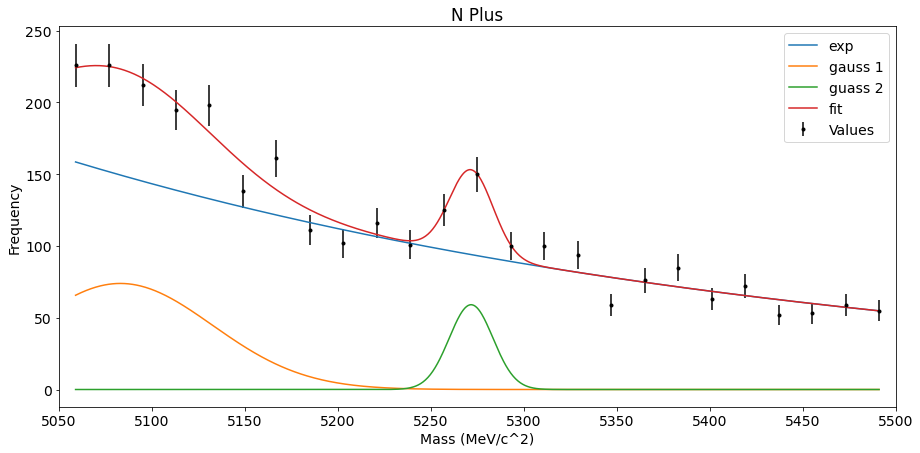

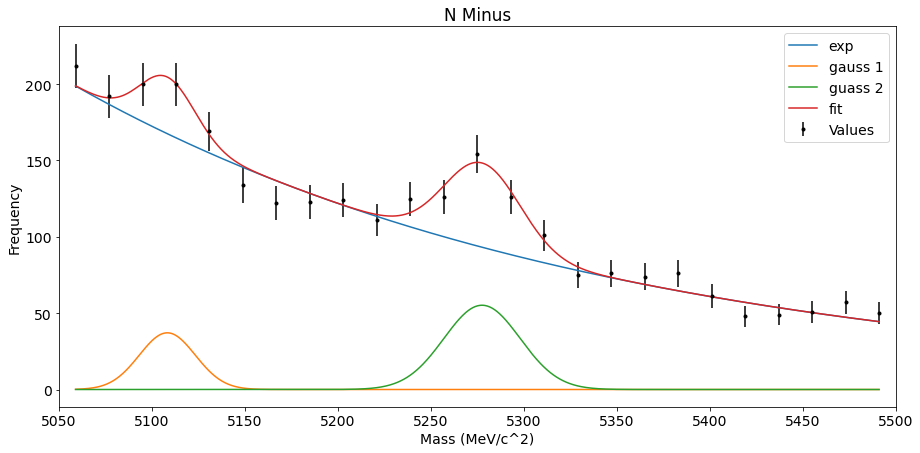

In [20]:
x_pos, y_pos = plot_resonant_cut(mass_asym_region_pos, 'N Plus')
yfit_pos, popt_pos = fit(fitting_func, x_pos, y_pos, [4.58061153e+04, 1.06520033e-03, 9.27486437e+01, 5.08564026e+03,
 4.32309356e+01, 2.31380945e+02, 5.28254844e+03, 1.92424648e+01])
x_values_pos, y_gauss_pos, y_exp_pos, bin_w_pos, popt_pos = plot_resonant_cut_fit(mass_asym_region_pos, yfit_pos, 'N Plus', popt_pos)
N_pos = calculate_area(gauss, 5100, 5400, (popt_pos[5], popt_pos[6], popt_pos[7]))

x_neg, y_neg = plot_resonant_cut(mass_asym_region_neg, 'N Minus')
yfit_neg, popt_neg = fit(fitting_func, x_neg, y_neg, [4.58061153e+04, 1.06520033e-03, 9.27486437e+01, 5.08564026e+03,
 4.32309356e+01, 2.31380945e+02, 5.28254844e+03, 1.92424648e+01])
x_values_neg, y_gauss_neg, y_exp_neg, bin_w_neg, popt_neg = plot_resonant_cut_fit(mass_asym_region_neg, yfit_neg, 'N Minus', popt_neg)
N_neg = calculate_area(gauss, 5100, 5400, (popt_neg[5], popt_neg[6], popt_neg[7]))

In [21]:
local_asymmetry = (N_neg - N_pos)/(N_neg + N_pos)
local_asymmetry_unc = np.sqrt((1-local_asymmetry**2)/(N_neg + N_pos))


print(f"Percent asymmetry: ({local_asymmetry*100:.3} ± {local_asymmetry_unc*100:.2})%")

Percent asymmetry: (23.9 ± 1.4)%


### Fitting Systematic Uncertainty

Chi-squared: 42.227
Degrees of freedom: 17
Reduced Chi-squared: 2.484


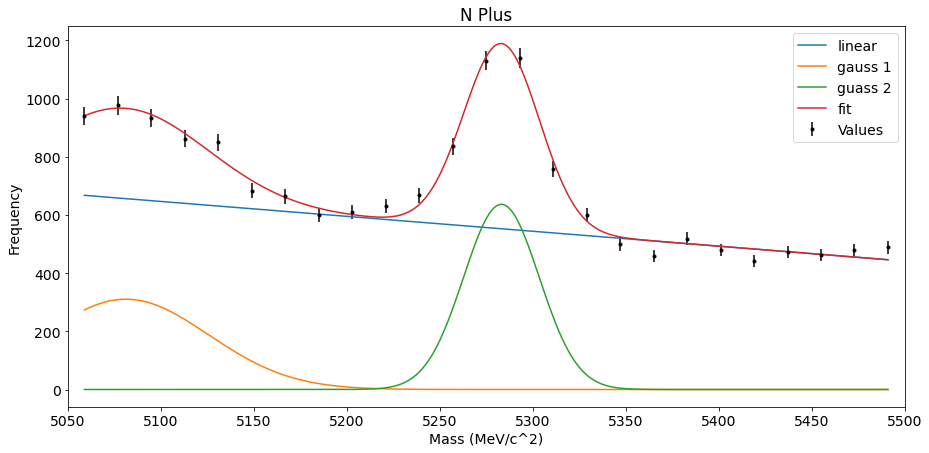

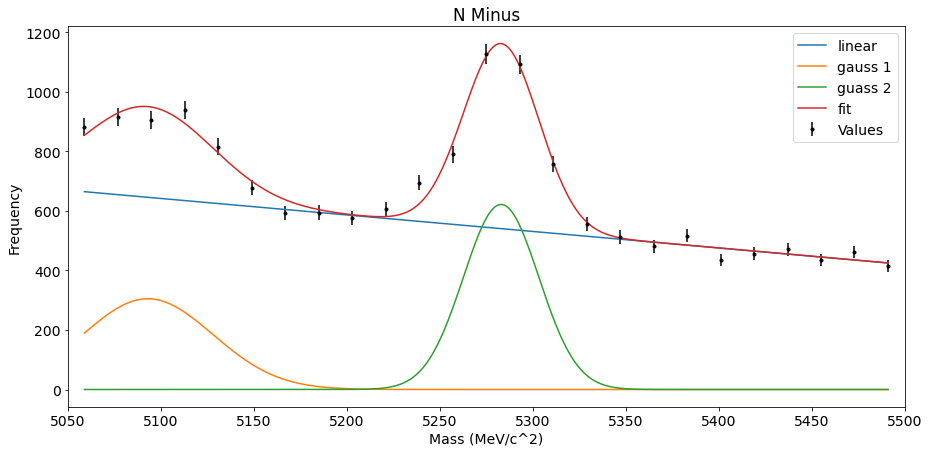

In [22]:
def gauss(x, A, x0, sigma): 
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss2(x, A2, x02, sigma2): 
    return A2 * np.exp(-(x - x02) ** 2 / (2 * sigma2 ** 2))

def linear(x, a, b):
    return a * x + b

def fitting_func(x, a, b, A, x0, sigma, A2, x02, sigma2):
    return np.array( gauss(x, A, x0, sigma) + linear(x, a, b) + gauss2(x, A2, x02, sigma2))


def fit(f, x, y, guess):
    popt, pcov = curve_fit(f, x, y, p0=guess, maxfev = 500000)
    yfit = f(x, *popt)
    return yfit, popt


yfit, popt = fit(fitting_func, x, y, [4.58061153e+04, 1.06520033e-03, 9.27486437e+01, 5.08564026e+03,
 4.32309356e+01, 2.31380945e+02, 5.28254844e+03, 1.92424648e+01])


def calculate_chi_squared(observed, expected):
    residuals = observed - expected
    chi_squared = np.sum(residuals**2 / expected)
    return chi_squared


chi_squared = calculate_chi_squared(y, yfit)
dof = len(y) - len(popt)
reduced_chi_squared = chi_squared/dof

print(f"Chi-squared: {chi_squared:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"Reduced Chi-squared: {reduced_chi_squared:.3f}")


def plot_resonant_cut_fit(inv_mass, yfit, title, popt):
    # Create a histogram using np.histogram
    counts, bin_edges = np.histogram(inv_mass, range=(5050, 5500), bins=N_BIN)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]

    plt.figure(figsize=(15, 7))
    
    # Create a scatter plot of peak values against bin centers
#    plt.scatter(bin_centers, counts, marker='x', color='k', label='Peak Values', s=60, linewidths=2)
    plt.errorbar(bin_centers, counts, np.sqrt(counts), marker='.', color='k', label='Values', linestyle='')
#    plt.plot(bin_centers, yfit)
    
    y_exp = linear(bin_centers, popt[0], popt[1])
    y_gauss = gauss(bin_centers, popt[2], popt[3], popt[4])
    y_gauss2 = gauss(bin_centers, popt[5], popt[6], popt[7])
    
    x_vals_for_plot = np.linspace(min(bin_centers), max(bin_centers), 1000)
    y_linear_for_plot = linear(x_vals_for_plot, popt[0], popt[1])
    y_gauss_for_plot = gauss(x_vals_for_plot, popt[2], popt[3], popt[4])
    y_gauss2_for_plot = gauss(x_vals_for_plot, popt[5], popt[6], popt[7])
    y_fitting_func_for_plot = fitting_func(x_vals_for_plot, *popt)

    plt.plot(x_vals_for_plot, y_linear_for_plot, label='linear')
    plt.plot(x_vals_for_plot, y_gauss_for_plot, label='gauss 1')
    plt.plot(x_vals_for_plot, y_gauss2_for_plot, label='guass 2')
    plt.plot(x_vals_for_plot, y_fitting_func_for_plot, label='fit')
    
    plt.xlim(5050, 5500)
    plt.xlabel('Mass (MeV/c^2)')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    return bin_centers, y_gauss, y_exp, bin_width, popt


def calculate_area(func, start, end, popt):
    area, _ = quad(func, start, end, args=(popt))
    return area


x_pos, y_pos = plot_resonant_cut(inv_mass_resonant_cut_pos, 'N Plus')
yfit_pos, popt_pos = fit(fitting_func, x_pos, y_pos, [4.58061153e+04, 1.06520033e-03, 9.27486437e+01, 5.08564026e+03,
 4.32309356e+01, 2.31380945e+02, 5.28254844e+03, 1.92424648e+01])
x_values_pos, y_gauss_pos, y_exp_pos, bin_w_pos, popt_pos = plot_resonant_cut_fit(inv_mass_resonant_cut_pos, yfit_pos, 'N Plus', popt_pos)
N_pos = calculate_area(gauss, 5100, 5400, (popt_pos[5], popt_pos[6], popt_pos[7]))

x_neg, y_neg = plot_resonant_cut(inv_mass_resonant_cut_neg, 'N Minus')
yfit_neg, popt_neg = fit(fitting_func, x_neg, y_neg, [4.58061153e+04, 1.06520033e-03, 9.27486437e+01, 5.08564026e+03,
 4.32309356e+01, 2.31380945e+02, 5.28254844e+03, 1.92424648e+01])
x_values_neg, y_gauss_neg, y_exp_neg, bin_w_neg, popt_neg = plot_resonant_cut_fit(inv_mass_resonant_cut_neg, yfit_neg, 'N Minus', popt_neg)
N_neg = calculate_area(gauss, 5100, 5400, (popt_neg[5], popt_neg[6], popt_neg[7]))

In [23]:
fit_asymmetry = (N_neg - N_pos)/(N_neg + N_pos)
fit_asymmetry_unc = np.sqrt((1-fit_asymmetry**2)/(N_neg + N_pos))

print(f"Percent asymmetry: ({global_asymmetry*100:.3} ± {fit_asymmetry_unc*100:.2})%")

sys_unc_from_fit = abs(fit_asymmetry*100 - global_asymmetry*100)

print(f"Percent asymmetry from fit: {fit_asymmetry*100:.3} {fit_asymmetry_unc*100}%")

print(f"\nSystematic uncertainty from fit: {sys_unc_from_fit:.2f} %")

Percent asymmetry: (-0.793 ± 0.4)%
Percent asymmetry from fit: -1.25 0.39505894784539414%

Systematic uncertainty from fit: 0.46 %


In [24]:
total_sys_unc = np.sqrt(sys_unc_from_fit**2 + sys_unc_from_avg**2)

print(f'Total systematic uncertainty: {total_sys_unc:.2f} %')

Total systematic uncertainty: 1.87 %


In [25]:
significance_of_results = (local_asymmetry*100) / (local_asymmetry_unc*100 + total_sys_unc)

print(f"Percent local asymmetry: ({local_asymmetry*100:.3} ± {local_asymmetry_unc*100:.2} ± {total_sys_unc:.2})%")
print(f"\nResults have a significance of {significance_of_results:.3} sigma, and hence meet the criteria for a discovery of CP violation (5 sigma).")

Percent local asymmetry: (23.9 ± 1.4 ± 1.9)%

Results have a significance of 7.23 sigma, and hence meet the criteria for a discovery of CP violation (5 sigma).


/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


Chi-squared: 23.572
Degrees of freedom: 15
Reduced Chi-squared: 1.571


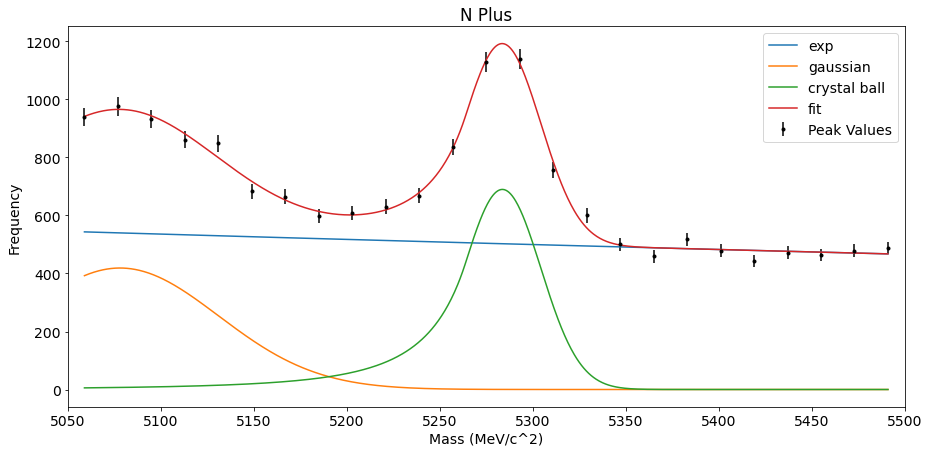

/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


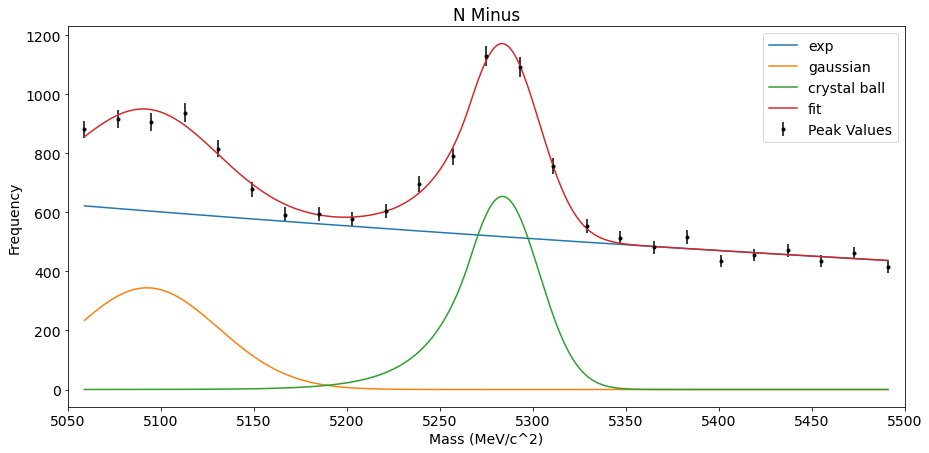

In [26]:
from scipy.stats import crystalball

def crystal_ball(x, beta, m, loc, scale, h):
    # Calculate the Crystal Ball PDF at the given x values
    return crystalball.pdf(x, beta, m, loc, scale) * h

def gauss(x, A, x0, sigma): 
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def exp(x, a, b):
    return a * np.exp(- b * x)

def fitting_func(x, a, b, A, x0, sigma, beta, m, loc, scale, h):
    return np.array( gauss(x, A, x0, sigma) + exp(x, a, b) + crystal_ball(x, beta, m, loc, scale, h))


def fit(f, x, y, guess):
    popt, pcov = curve_fit(f, x, y, p0=guess)
    yfit = f(x, *popt)
    return yfit, popt

initial_guesses = [
    # Parameters for the exponential
    4.58061153e+04,  # a
    1.06520033e-03,  # b
    # Parameters for the Gaussian (for the background to the left)
    92.7486437,      # A, reduced amplitude
    5085.64026,      # x0, shifted to the left
    43.2309356,      # sigma, broader
    # Parameters for the Crystal Ball (for the central peak)
    0.87,            # beta, tail parameter
    6.26,            # m, power of the tail
    5283,            # loc, peak location
    20,              # scale, narrower peak
    33094            # height
]
    
yfit, popt = fit(fitting_func, x, y, initial_guesses)


def calculate_chi_squared(observed, expected):
    residuals = observed - expected
    chi_squared = np.sum(residuals**2 / expected)
    return chi_squared


chi_squared = calculate_chi_squared(y, yfit)
dof = len(y) - len(popt)
reduced_chi_squared = chi_squared/dof

print(f"Chi-squared: {chi_squared:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"Reduced Chi-squared: {reduced_chi_squared:.3f}")


def plot_resonant_cut_fit(inv_mass, yfit, title, popt):
    # Create a histogram using np.histogram
    counts, bin_edges = np.histogram(inv_mass, range=(5050, 5500), bins=N_BIN)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]

    plt.figure(figsize=(15, 7))

    plt.errorbar(bin_centers, counts, np.sqrt(counts), marker='.', color='k', label='Peak Values', linestyle='')
    
    x_vals_for_plot = np.linspace(min(bin_centers), max(bin_centers), 1000)
    y_exp_for_plot = exp(x_vals_for_plot, popt[0], popt[1])
    y_gauss_for_plot = gauss(x_vals_for_plot, popt[2], popt[3], popt[4])
    y_crystal_ball_for_plot = crystal_ball(x_vals_for_plot, popt[5], popt[6], popt[7], popt[8], popt[9])
    y_fitting_func_for_plot = fitting_func(x_vals_for_plot, *popt)

    plt.plot(x_vals_for_plot, y_exp_for_plot, label='exp')
    plt.plot(x_vals_for_plot, y_gauss_for_plot, label='gaussian')
    plt.plot(x_vals_for_plot, y_crystal_ball_for_plot, label='crystal ball')
    plt.plot(x_vals_for_plot, y_fitting_func_for_plot, label='fit')
    
    plt.xlabel('Mass (MeV/c^2)')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xlim(5050, 5500)
    plt.legend()
    plt.show()  # Show the saved figure
    return bin_centers, y_exp, bin_width, popt


x_pos, y_pos = plot_resonant_cut(inv_mass_resonant_cut_pos, 'N Plus')
yfit_pos, popt_pos = fit(fitting_func, x_pos, y_pos, initial_guesses)
x_values_pos, y_exp_pos, bin_w_pos, popt_pos = plot_resonant_cut_fit(inv_mass_resonant_cut_pos, yfit_pos, 'N Plus', popt_pos)
N_pos = calculate_area(crystal_ball, 5100, 5400, (popt_pos[5], popt_pos[6], popt_pos[7], popt_pos[8], popt_pos[9]))

x_neg, y_neg = plot_resonant_cut(inv_mass_resonant_cut_neg, 'N Minus')
yfit_neg, popt_neg = fit(fitting_func, x_neg, y_neg, initial_guesses)
x_values_neg, y_exp_neg, bin_w_neg, popt_neg = plot_resonant_cut_fit(inv_mass_resonant_cut_neg, yfit_neg, 'N Minus', popt_neg)
N_neg = calculate_area(crystal_ball, 5100, 5400, (popt_neg[5], popt_neg[6], popt_neg[7], popt_neg[8], popt_neg[9]))

In [27]:
cb_asymmetry = (N_neg - N_pos)/(N_neg + N_pos)
cb_asymmetry_unc = np.sqrt((1-fit_asymmetry**2)/(N_neg + N_pos))

print(f"Percent asymmetry: ({global_asymmetry*100:.3} ± {global_asymmetry_unc*100:.2})%")

sys_unc_from_cb = abs(cb_asymmetry*100 - global_asymmetry*100)

print(f"Percent asymmetry from fit: {cb_asymmetry*100:.3} %")

print(f"\nSystematic uncertainty from fit: {sys_unc_from_cb:.2f} %")

Percent asymmetry: (-0.793 ± 0.39)%
Percent asymmetry from fit: -8.43 %

Systematic uncertainty from fit: 7.64 %


/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


Chi-squared: 302.836
Degrees of freedom: 15
Reduced Chi-squared: 20.189


/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


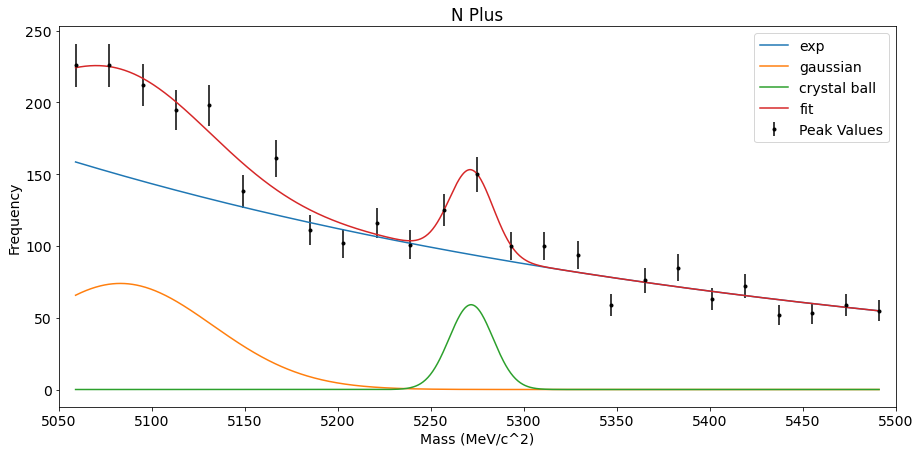

/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


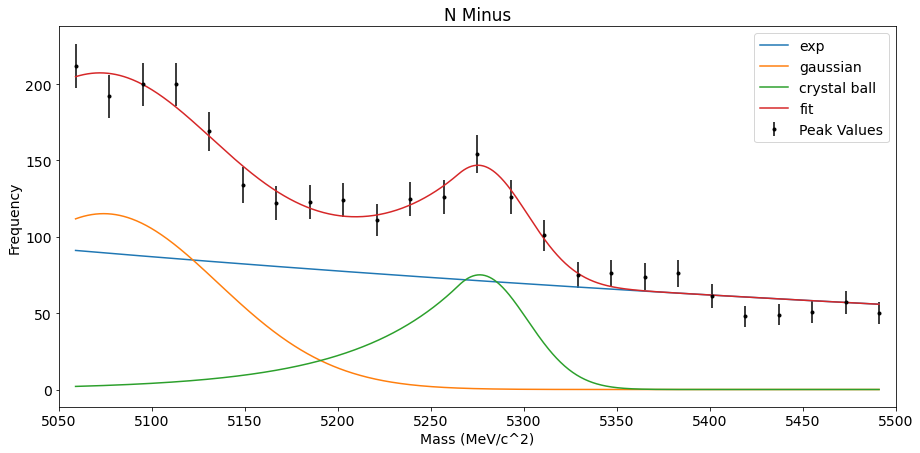

In [28]:
from scipy.stats import crystalball

def crystal_ball(x, beta, m, loc, scale, h):
    # Calculate the Crystal Ball PDF at the given x values
    return crystalball.pdf(x, beta, m, loc, scale) * h

def gauss(x, A, x0, sigma): 
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def exp(x, a, b):
    return a * np.exp(- b * x)

def fitting_func(x, a, b, A, x0, sigma, beta, m, loc, scale, h):
    return np.array( gauss(x, A, x0, sigma) + exp(x, a, b) + crystal_ball(x, beta, m, loc, scale, h))


def fit(f, x, y, guess):
    popt, pcov = curve_fit(f, x, y, p0=guess)
    yfit = f(x, *popt)
    return yfit, popt

def fit2(f, x, y, guess2):
    popt, pcov = curve_fit(f, x, y, p0=guess2)
    yfit = f(x, *popt)
    return yfit, popt

initial_guesses = [
    # Parameters for the exponential
    4.58061153e+04,  # a
    1.06520033e-03,  # b
    # Parameters for the Gaussian (for the background to the left)
    92.7486437,      # A, reduced amplitude
    5085.64026,      # x0, shifted to the left
    43.2309356,      # sigma, broader
    # Parameters for the Crystal Ball (for the central peak)
    0.87,            # beta, tail parameter
    6.26,            # m, power of the tail
    5283,            # loc, peak location
    20,              # scale, narrower peak
    1500             # height
]

initial_guesses2 = [
    # Parameters for the exponential
    4.58061153e+04,  # a
    1.06520033e-03,  # b
    # Parameters for the Gaussian (for the background to the left)
    92.7486437,      # A, reduced amplitude
    5085.64026,      # x0, shifted to the left
    43.2309356,      # sigma, broader
    # Parameters for the Crystal Ball (for the central peak)
    0.87,            # beta, tail parameter
    10,              # m, power of the tail
    5283,            # loc, peak location
    20,              # scale, narrower peak
    1250             # height
]
    
yfit, popt = fit(fitting_func, x, y, initial_guesses)


def calculate_chi_squared(observed, expected):
    residuals = observed - expected
    chi_squared = np.sum(residuals**2 / expected)
    return chi_squared


chi_squared = calculate_chi_squared(y, yfit)
dof = len(y) - len(popt)
reduced_chi_squared = chi_squared/dof

print(f"Chi-squared: {chi_squared:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"Reduced Chi-squared: {reduced_chi_squared:.3f}")


def plot_resonant_cut_fit(inv_mass, yfit, title, popt):
    # Create a histogram using np.histogram
    counts, bin_edges = np.histogram(inv_mass, range=(5050, 5500), bins=N_BIN)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]

    plt.figure(figsize=(15, 7))

    plt.errorbar(bin_centers, counts, np.sqrt(counts), marker='.', color='k', label='Peak Values', linestyle='')
    
    x_vals_for_plot = np.linspace(min(bin_centers), max(bin_centers), 1000)
    y_exp_for_plot = exp(x_vals_for_plot, popt[0], popt[1])
    y_gauss_for_plot = gauss(x_vals_for_plot, popt[2], popt[3], popt[4])
    y_crystal_ball_for_plot = crystal_ball(x_vals_for_plot, popt[5], popt[6], popt[7], popt[8], popt[9])
    y_fitting_func_for_plot = fitting_func(x_vals_for_plot, *popt)

    plt.plot(x_vals_for_plot, y_exp_for_plot, label='exp')
    plt.plot(x_vals_for_plot, y_gauss_for_plot, label='gaussian')
    plt.plot(x_vals_for_plot, y_crystal_ball_for_plot, label='crystal ball')
    plt.plot(x_vals_for_plot, y_fitting_func_for_plot, label='fit')
    
    plt.xlabel('Mass (MeV/c^2)')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xlim(5050, 5500)
    plt.legend()
    plt.show()  # Show the saved figure
    return bin_centers, y_exp, bin_width, popt


x_pos, y_pos = plot_resonant_cut(mass_asym_region_pos, 'N Plus')
yfit_pos, popt_pos = fit(fitting_func, x_pos, y_pos, initial_guesses)
x_values_pos, y_exp_pos, bin_w_pos, popt_pos = plot_resonant_cut_fit(mass_asym_region_pos, yfit_pos, 'N Plus', popt_pos)
N_pos = calculate_area(crystal_ball, 5100, 5400, (popt_pos[5], popt_pos[6], popt_pos[7], popt_pos[8], popt_pos[9]))

x_neg, y_neg = plot_resonant_cut(mass_asym_region_neg, 'N Minus')
yfit_neg, popt_neg = fit2(fitting_func, x_neg, y_neg, initial_guesses2)
x_values_neg, y_exp_neg, bin_w_neg, popt_neg = plot_resonant_cut_fit(mass_asym_region_neg, yfit_neg, 'N Minus', popt_neg)
N_neg = calculate_area(crystal_ball, 5100, 5400, (popt_neg[5], popt_neg[6], popt_neg[7], popt_neg[8], popt_neg[9]))

In [29]:
cb_asymmetry = (N_neg - N_pos)/(N_neg + N_pos)
cb_asymmetry_unc = np.sqrt((1-fit_asymmetry**2)/(N_neg + N_pos))

print(f"Percent asymmetry from fit: ({cb_asymmetry*100:.3} ± {cb_asymmetry_unc*100:.2}) %")

Percent asymmetry from fit: (60.0 ± 1.1) %
